In [1]:
import os
os.environ['OMP_NUM_THREADS'] = str(os.cpu_count())

import numpy as np
import matplotlib.pyplot as plt
import gym
import random

In [2]:
from IPython.display import display, HTML, Video
from matplotlib import animation


In [3]:
def display_frames_as_gif(frames):
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                       interval=20)
    return HTML(anim.to_jshtml())

In [4]:
from collections import namedtuple

Tr = namedtuple('tr', ('name_a', 'value_b'))
Tr_object = Tr('是名稱A', 100)

print(Tr_object)
print(Tr_object.value_b)

tr(name_a='是名稱A', value_b=100)
100


In [5]:
from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


In [6]:
ENV = 'CartPole-v0'
GAMMA = 0.99
MAX_STEPS = 200
NUM_EPISODES = 500

In [7]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.index = 0
        
    def push(self, state, action, state_next, reward):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            
        self.memory[self.index] = Transition(state, action, state_next, reward)
        
        self.index = (self.index + 1) % self.capacity
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [8]:
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000

class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions
        self.memory = ReplayMemory(CAPACITY)
        
        self.model = nn.Sequential(
            nn.Linear(num_states, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, num_actions)
        )
        
        print(self.model)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr = 0.0001)
        
    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        
        transitions = self.memory.sample(BATCH_SIZE)
        
        batch = Transition(*zip(*transitions))
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        self.model.eval()
        
        state_action_values = self.model(state_batch).gather(1, action_batch)
        
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))
        
        next_state_values = torch.zeros(BATCH_SIZE)
        
        next_state_values[non_final_mask] = self.model(
            non_final_next_states).max(1)[0].detach()
        
        expected_state_action_values = reward_batch + GAMMA * next_state_values
        
        self.model.train()
        
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def decide_action(self, state, episode):
        epsilon = 0.5 * (1 / (episode + 1))
        
        if epsilon <= np.random.uniform(0, 1):
            self.model.eval()
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
        else:
            action = torch.LongTensor([[random.randrange(self.num_actions)]])
            
        return action

In [9]:
class Agent:
    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)
        
    def update_q_function(self):
        self.brain.replay()
        
    def get_action(self, state, episode):
        action = self.brain.decide_action(state, episode)
        return action
    
    def memorize(self, state, action, state_next, reward):
        self.brain.memory.push(state, action, state_next, reward)
        

In [10]:
class Environment:
    def __init__(self):
        self.env = gym.make(ENV)
        num_states = self.env.observation_space.shape[0]
        num_actions = self.env.action_space.n
        
        self.agent = Agent(num_states, num_actions)
        
    def run(self):
        episode_10_list = np.zeros(10)
        complete_episodes = 0
        episode_final = False
        
        frames = []
        
        for episode in range(NUM_EPISODES):
            observation = self.env.reset()
            
            state = observation
            state = torch.from_numpy(state).type(torch.FloatTensor)
            state = torch.unsqueeze(state, 0)
            
            for step in range(MAX_STEPS):
                if episode_final is True:
                    frames.append(self.env.render(mode='rgb_array'))
                    
                action = self.agent.get_action(state, episode)
                
                observation_next, _, done, _ = self.env.step(action.item())
                
                if done:
                    state_next = None
                    episode_10_list = np.hstack((episode_10_list[1:], step + 1))
                    
                    if step < 195:
                        reward = torch.FloatTensor([-1.0])
                        complete_episodes = 0
                    else:
                        reward = torch.FloatTensor([1.0])
                        complete_episodes = complete_episodes + 1
                else:
                    reward = torch.FloatTensor([0.0])
                    state_next = observation_next
                    state_next = torch.from_numpy(state_next).type(torch.FloatTensor)
                    state_next = torch.unsqueeze(state_next, 0)
                    
                self.agent.memorize(state, action, state_next, reward)
                
                self.agent.update_q_function()
                
                state = state_next
                
                if done:
                    print('%d Episode: Finished after %d steps: 10 episode avg step = %.1lf' % (
                        episode, step + 1, episode_10_list.mean()
                    ))
                    break
                
            if episode_final is True:
                display_frames_as_gif(frames)
                break
                    
            if complete_episodes >= 10:
                print('10 episode success')
                episode_final = True
                    

Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 11 steps: 10 episode avg step = 1.1
1 Episode: Finished after 8 steps: 10 episode avg step = 1.9
2 Episode: Finished after 8 steps: 10 episode avg step = 2.7


/tmp/ipykernel_49162/3223327917.py:49: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /build/python-pytorch/src/pytorch-1.9.0-opt-cuda/aten/src/ATen/native/IndexingUtils.h:29.)
  next_state_values[non_final_mask] = self.model(


3 Episode: Finished after 12 steps: 10 episode avg step = 3.9
4 Episode: Finished after 10 steps: 10 episode avg step = 4.9
5 Episode: Finished after 9 steps: 10 episode avg step = 5.8
6 Episode: Finished after 9 steps: 10 episode avg step = 6.7
7 Episode: Finished after 11 steps: 10 episode avg step = 7.8
8 Episode: Finished after 9 steps: 10 episode avg step = 8.7
9 Episode: Finished after 10 steps: 10 episode avg step = 9.7
10 Episode: Finished after 11 steps: 10 episode avg step = 9.7
11 Episode: Finished after 10 steps: 10 episode avg step = 9.9
12 Episode: Finished after 9 steps: 10 episode avg step = 10.0
13 Episode: Finished after 8 steps: 10 episode avg step = 9.6
14 Episode: Finished after 9 steps: 10 episode avg step = 9.5
15 Episode: Finished after 8 steps: 10 episode avg step = 9.4
16 Episode: Finished after 10 steps: 10 episode avg step = 9.5
17 Episode: Finished after 10 steps: 10 episode avg step = 9.4
18 Episode: Finished after 8 steps: 10 episode avg step = 9.3
19 Epi

134 Episode: Finished after 22 steps: 10 episode avg step = 28.6
135 Episode: Finished after 37 steps: 10 episode avg step = 29.3
136 Episode: Finished after 41 steps: 10 episode avg step = 30.0
137 Episode: Finished after 33 steps: 10 episode avg step = 30.6
138 Episode: Finished after 28 steps: 10 episode avg step = 30.7
139 Episode: Finished after 22 steps: 10 episode avg step = 30.0
140 Episode: Finished after 30 steps: 10 episode avg step = 30.7
141 Episode: Finished after 27 steps: 10 episode avg step = 30.7
142 Episode: Finished after 33 steps: 10 episode avg step = 30.1
143 Episode: Finished after 27 steps: 10 episode avg step = 30.0
144 Episode: Finished after 32 steps: 10 episode avg step = 31.0
145 Episode: Finished after 46 steps: 10 episode avg step = 31.9
146 Episode: Finished after 25 steps: 10 episode avg step = 30.3
147 Episode: Finished after 31 steps: 10 episode avg step = 30.1
148 Episode: Finished after 24 steps: 10 episode avg step = 29.7
149 Episode: Finished aft

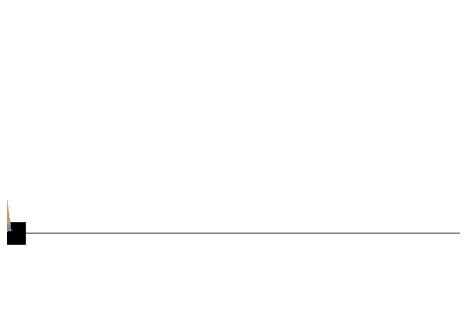

In [11]:
cartpole_env = Environment()
cartpole_env.run()